+# Neural Network Builder for Image Classification Tasks with CIFAR10 and Tensorflow

## 1. Introduction
### 1.1 Summary
This notebooks contains a step by step example of building a convolutional neural network model with Tensorflow.
<br>
Based on the <a href="https://www.cs.toronto.edu/~kriz/cifar.html" target="_blank">CIFAR10 Dataset</a>,
this model is suitable for performing **classification tasks**, recognizing 10 different entities:
<br>
airplanes, automobiles, birds, cats, deer, dogs, frogs, horses, ships and trucks.

### 1.2 Requirements
The requiements to run this notebook can be installed via requirements.txt, as demonstrated in <a href="https://video/url/goes/here" trarget="_blank">this tutorial</a>.<br>
Or alternativley, you can do it directly from this notebook by running the following cell:

In [52]:
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install pillow

### 1.3 Imports

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## 2. Load Dataset
### 2.1 Fetch Data
in the following cell we will load the CIFAR10 dataset, and check the shape and total number of dataset samples.

In [54]:
from tensorflow.keras import datasets
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

print("{} train samples and {} test samples\n".format(len(x_train), len(x_test)))
print("train samples shape:", x_train.shape)
print("train labels shape:", y_train.shape)

50000 train samples and 10000 test samples

train samples shape: (50000, 32, 32, 3)
train labels shape: (50000, 1)


### 2.2 Data Overview

#### 2.2.1 Train Versus Test
we see that CIFAR10 contains:
- ```50,000``` train samples
- ```10,000``` test samples

#### 2.2.2 Sample Structure
all samples are:
- ```32px``` wide
- ```32px``` high
- ```3``` colour channels deep (in other words, ```RGB``` images)

#### 2.2.3 Label Structure
all labels contain a single value, that represents the entity that appears in the sample.
<br>
**for example:** if the sample is a photo of a ```cat``` - then the label will be ```3```.

### 2.3 Translate Class Labels to Class Names
the following dictionary maps the numeric labels of CIFAR10 to their corresponding class names.<br>
once we run it, we won't have to worry about deciphering the meaning behind the numbers - we can easily convert them to their name representation.

In [55]:
class_names = {
    0: 'bee',
    1: 'elephant',
    2: 'giraffe',
    3: 'koala',
    4: 'orangutan',
    5: 'panda',
    6: 'panther',
    7: 'horse',
    8: 'penguen',
    9: 'polar bear',
    10: 'turtle',
    11: 'rhino',
}

### 2.4 Visualize Dataset

Let's plot 9 random samples from the dataset along with their labels to verify our mapping is correct.
<br>
each time this cell runs, a different batch of samples will be plotted.

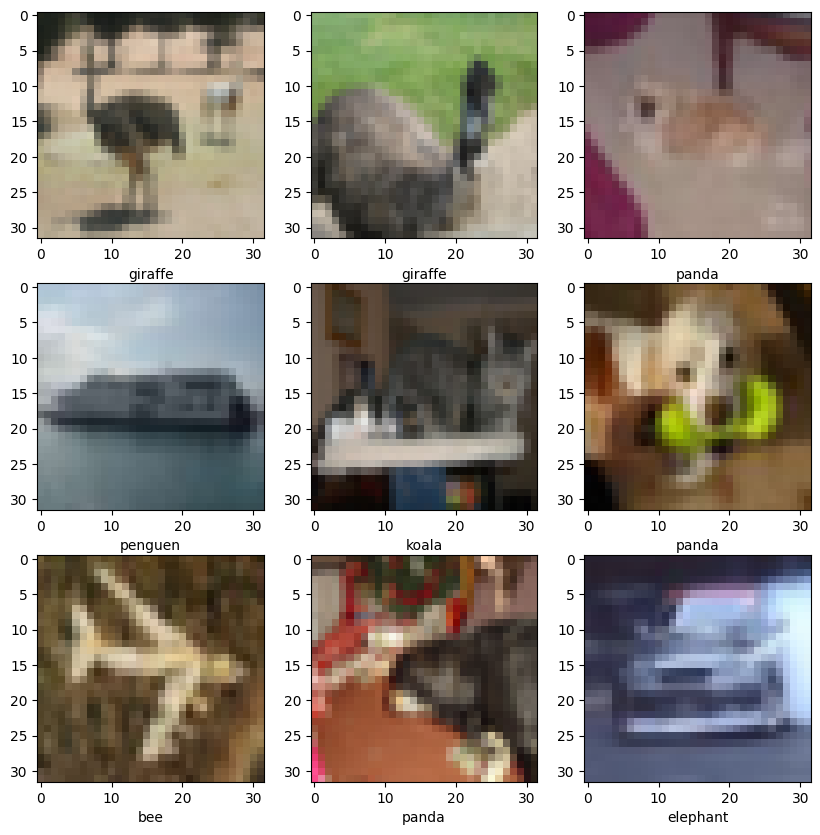

In [56]:
# select a random set of 9 images
idx = np.random.randint(len(x_train) - 9)

plt.figure(figsize=(10,10))
for i in range(9):
    # plot each sample
    plt.subplot(3, 3, i+1)   
    plt.imshow(x_train[i + idx]) 
    plt.xlabel(class_names[(y_train[i + idx][0])])

# display results
plt.show()

## 3. Data Reduction

before loading the data into a neural network, we will implement some data reduction tenchiques to ensure maximum efficiency.

### 3.1 Samples Reduction

### 3.1.1 Current Sample Values
Each pixel in each image stores colour intensity values in the range of ```0-255```, where:
- 0 represents the minimum colour intencity.
- 255 represents the maximum clour intencity.

RGB representation:
- in RGB, **pure red** is denoted with (255, 0, 0) with maximum intensity on the red channel.
- in RGB, **pure green** is denoted with (0, 255, 0) with maximum intensity on the green channel.
- in RGB, **pure blue** is denoted with (0, 0, 255) with maximum intensity on the blue channel.
- in RGB, **pure yellow** is denoted with (255, 255, 0) with maximum intensity on the red and green channels.

let's quickly print an example of some pixel values from the first train sample.

In [57]:
# [first sample], [first colour channel], [first row of pixels]
print(x_train[0][0][0])

[59 62 63]


### 3.1.2 Sample Normalization

The problem is - the values we just printed span across a very large range!
<br>
We can, in fact, reduce it by mapping each value in the range of ```0-255``` to an equivalent value in the range of ```0-1```.
<br>
this technique is called **Normalization** where the relationship between the values remains the same, but they are reduced to a smaller scale.
<br>
We'll simply divide each pixel value in our samples by 255, like so:

In [58]:
x_train = x_train / 255.
x_test = x_test / 255.

### 3.1.3 Updated Sample Values

When we print the exact same example, we now get the same values but at a different scale.
<br>
We can actually verify that our images did not change their appearance, by **re-running the plotting cell** from above.
<br>
You will see that our reduction technique did not result in any loss of information.

In [59]:
print(x_train[0][0][0])

[0.23137255 0.24313725 0.24705882]


### 3.2 Labels Reduction

#### 3.2.1 Current Label Values
currently, our label stores an integer value that represents a certain class

In [60]:
print("class {} represents a {}".format(y_train[0][0], class_names[y_train[0][0]]))

class 6 represents a panther


### 3.2.2 One Hot Encoding

The problem is - once again we are dealing with a **relativley large search space** of values in the range of ```0-9```.
<br>
However, we cannot normaize these values because they represent distinct categories (in other words - they are discrete and therefore we cannot treat them like continous values). In these cases we use a different technique called **One Hot Encoding**.
<br>
Where we convert decimal values to their binary representation. Such that:
- the class of ```0``` is One-Hot-Encoded into ```1000000000```
- the class of ```1``` is One-Hot-Encoded into ```0100000000```
- the class of ```2``` is One-Hot-Encoded into ```0010000000```
- the class of ```9``` is One-Hot-Encoded into ```0000000001```

Let's quickly implement it in the next cell

In [61]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### 3.2.3 Updated Label Values

When we print the exact same label, we now get the same values but they are represented differently.

In [62]:
print("class {} represents a {}".format(y_train[0], class_names[np.argmax(y_train[0])]))

class [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.] represents a panther


## 4. Create Baseline Neural Netwok

Now it's time for a fun experiment! We will pick some arbitrary parameters for what we call a **Baseline Model**. This is the initial neural network that we begin our exploration process with. I highly encourage you to change some of the parameters and find how they affect the resuts.

## 4.1 Exploration Rules
you can remove, add or change the layers and their parameters, as long as you follow the following rules
- do not change the input shape, it must remain: ```input_shape=(32, 32, 3)```
- do not change the output units of the last Dense layer, it must remain: ```layers.Dense(10)```
- do not remove the Softmax layer, it must be last: ```layers.Softmax()```
- do not remove the Flatten layer, it must remain in between the Convolutional/MaxPooling layers and the Dense ones: ```layers.Flatten()```
- do not change the loss, it must remain ```loss = 'categorical_crossentropy'```
- do not change the evaluation metrics, as they are associated with the lost, they must remain at: ```metrics = ['accuracy']```

## 4.2 Create Model

In [63]:
from tensorflow.keras import Sequential, layers

def build_model():
    model = Sequential()
    # 32 output units, 3 filter size
    model.add(layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(layers.MaxPooling2D(pool_size=(2,2))) 
    # 32 output units, 5 filter size
    model.add(layers.Conv2D(32, 5, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))  
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10))
    model.add(layers.Softmax())
    
    model.compile(
        optimizer ='adam',
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'])
    return model

# create model
model = build_model()

# see model details
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_3 (Softmax)             │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,314 (618.41 KB)

 Trainable params: 158,314 (618.41 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Train Model

Once our data and model are ready, we can proceed with a process called training, where the model reviews and learns the data time and time again.
<br>
The process of repetition, allows the model to recognize patterns within the data as it observes it from different angles through different filters.

### 5.1 Beyond the Scope: Validation
Usually, to train a Baseline Model such as ours, we must perform a process called "validation". However, it's beyond the scope of this notebook, I will cover it in future tutorials.
<br>
If you'd still like to perform validation, this code will collect **both train and validation metrics** rather than just the train ones, as we do in the next cell:
- train metric: ```history.history['accuracy']```
- train metric: ```history.history['loss']```
- validation metric: ```history.history['val_accuracy']```
- validation metric: ```history.history['val_loss']```

```
# reserve samples for validation
valset_size = len(x_train) // 5
x_val = x_train[-valset_size:]
y_val = y_train[-valset_size:]
x_partial_train = x_train[:-valset_size]
y_partial_train = y_train[:-valset_size]

history = model.fit(
    x_train,
    y_train,
    epochs=2,
    validation_data=(x_val, y_val),
)
```

### 5.2 Train Rules
- **Epochs**: Each data sample passes through each model layer exactly ```number_of_epochs``` times. <br>Where epoch represents one model iteration over the data, in our case - we have ```10``` of them. <br>Please feel free to modify this value, but keep in mind - the more epochs the longer your model will train!
- **Save Model**: Once the training ends, we save our model as ```baseline.keras``` so we can load it and re-use it in the future without training.
- **History**: the history object stores a dictionary that tracks the ```accuracy``` and ```loss``` metrics for each epoch.
- **Loss**: loss must reduce over time, otherwise something is wrong!
- **Accuracy**: accuracy must improve over time, otherwise something is wrong!

### 5.3 Perform Training

In [64]:
%%time
history = model.fit(x_train, y_train, epochs=10)
model.save('baseline2.keras')

print("\ninitial accuracy: {} | latest accuracy: {}".format(history.history["accuracy"][0], history.history["accuracy"][-1]))
print("initial loss: {} | latest loss: {}".format(history.history["loss"][0], history.history["loss"][-1]))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.3967 - loss: 1.6602
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.6256 - loss: 1.0581
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6779 - loss: 0.9256
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.7057 - loss: 0.8384
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7305 - loss: 0.7666
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7465 - loss: 0.7152
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7643 - loss: 0.6626
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7843 - loss: 0.6098
Epoch 9/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.7943 - loss: 0.5826
Epoch 10/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8108 - loss: 0.5314

initial accuracy: 0.4962399899959564 | latest accuracy: 0.8053200244903564
initial loss: 1.4053066968917847

### 5.4 Plot Training Results

Please note, **if you've performed validation**, add the following lines of code right before ```plt.show()``` so you can compare between the training and validation results:
```
axis[0].plot(history.history["val_accuracy"])
axis[1].plot(history.history["val_loss"])
```
Otherwise, run the following cell as is to see the results of your training.
<br>
Please make sure your **accuracy grows** and your **loss reduces** gradually before proceeding.
<br>
If not - you'll need to revise the model along with other parameters you've changed earlier.

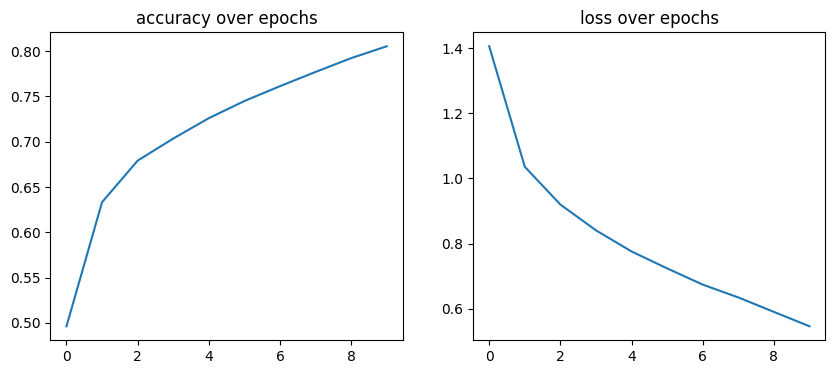

In [65]:
fig, axis = plt.subplots(1, 2, figsize=(10,4))  
axis[0].plot(history.history["accuracy"])
axis[0].set_title("accuracy over epochs")
axis[1].plot(history.history["loss"])
axis[1].set_title("loss over epochs")
plt.show()

## 6. Test Model

### 6.1 Perform Testing

The last stage before releasing our model into the wild - is testing it! We will use the ```x_test``` and ```y_test``` data which our model have never seen before - and we will check how well it classifies it.
<br>
The **test accuracy score** is given by how many examples our model **correctly classified** in total. Anything above 65 is great!

In [66]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\ntest accuracy score:', test_acc)

313/313 - 2s - 5ms/step - accuracy: 0.6980 - loss: 0.9394

test accuracy score: 0.6980000138282776


### 6.2 Verify Testing Results

Let's make sure the inner workings of the above function are match reality.<br>
Let's fetch the individual prediction for each sample and plot it along with its image.

#### 6.2.1 Fetch Predictions for each Sample

In [67]:
predictions = model.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


#### 6.2.2 Plot Samples Along with Their Predictions

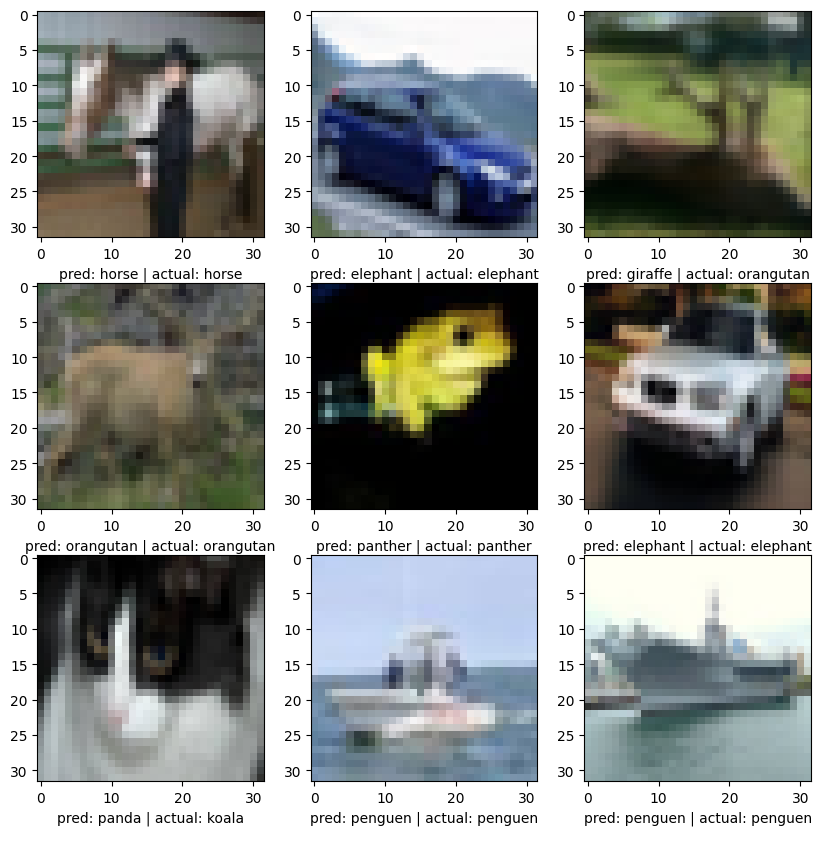

In [68]:
# select a random set of 9 test images
idx = np.random.randint(len(x_test) - 9)

plt.figure(figsize=(10,10))
for i in range(9):
    # plot each test image along with its prediction
    plt.subplot(3, 3, i+1)   
    plt.imshow(x_test[i + idx]) 
    plt.xlabel("pred: {} | actual: {}\n".format(class_names[np.argmax(predictions[i + idx])], class_names[np.argmax(y_test[i + idx])]))

# display results
plt.show()

## 7. The End!

Once you re-run the above cell and repeatedly see more correct predictions than incorrect ones - you're done with training! 
<br>
You can now proceed with testing your model in real world applications! 
- We'll use bigger images from our own collection!
- We'll create a nice interface where users can interact with our model without coding or knowing anything about Python

If you're curious to see how, this video tutorial of mine: <a href="https://link/to/video" target="_blank">Create ML GUI Application with Taipy</a> 
<br>
Will show you how to make a **Graphic User Interface** for the original model you found in this notebook.
<br>
Hoping to see you there! :)

\- Mariya